In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [25]:
# Load your country's dataset (example: Benin)
df = pd.read_csv("C:/Users/Gerji/Desktop/projects/solar-challenge-week1/data/togo-dapaong_qc.csv")

# Convert the Timestamp column to datetime (very important for time analysis)
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# See what your data looks like
print("✅ Data loaded successfully!")
print(df.head())
print("\nShape of dataset:", df.shape)


✅ Data loaded successfully!
            Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0 2021-10-25 00:01:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1 2021-10-25 00:02:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2 2021-10-25 00:03:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3 2021-10-25 00:04:00 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4 2021-10-25 00:05:00 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4      0.4  227.5      1.6  977         0            0.0   24.7   24.4   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       


--- Summary Statistics ---
                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000   
max              2022-10-25 00:00:00    1424.000000    1004.500000   
std                              NaN     322.532347     250.956962   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      116.444352     226.144375     219.568588      27.751788   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       0.000000       0.000000      24.200000

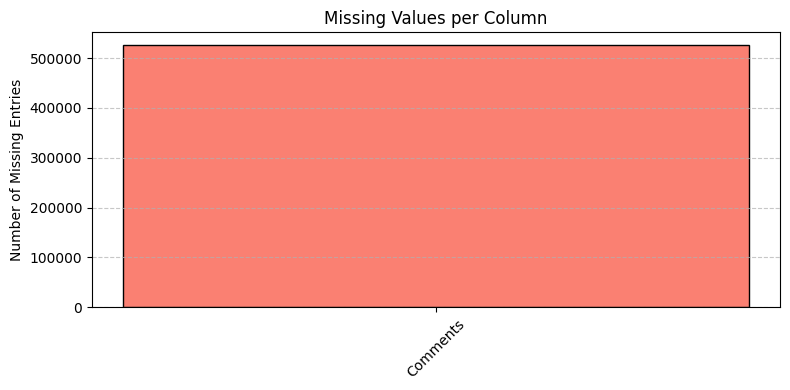

In [26]:
# Summary stats for numeric columns
print("\n--- Summary Statistics ---")
print(df.describe())

# Count missing values per column
missing = df.isna().sum()

# Filter only columns that have missing values
missing = missing[missing > 0]

# Bar chart of missing values
plt.figure(figsize=(8,4))
plt.bar(missing.index, missing.values, color="salmon", edgecolor="black")
plt.title("Missing Values per Column")
plt.ylabel("Number of Missing Entries")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


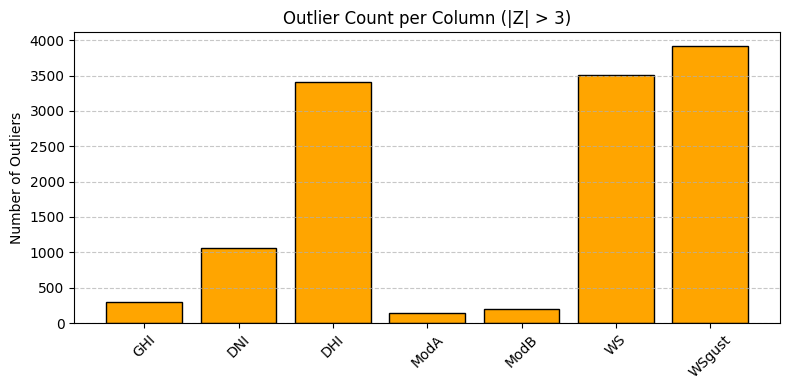

GHI        305
DNI       1062
DHI       3415
ModA       137
ModB       206
WS        3510
WSgust    3915
dtype: int64


In [27]:
# Columns to check 
target_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
numeric_cols = [col for col in target_cols if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

if len(numeric_cols) == 0:
    print("⚠️ No numeric columns found for outlier detection.")
else:
    # Compute Z-scores safely
    z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy="omit"))

    # Convert to DataFrame for easier labeling
    z_df = pd.DataFrame(z_scores, columns=numeric_cols)

    # Count outliers (|Z| > 3)
    outlier_counts = (z_df > 3).sum()

    # ✅ Plot bar chart
    plt.figure(figsize=(8,4))
    plt.bar(outlier_counts.index, outlier_counts.values, color="orange", edgecolor="black")
    plt.title("Outlier Count per Column (|Z| > 3)")
    plt.ylabel("Number of Outliers")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(outlier_counts)


In [28]:
# Fill missing numeric values with median
for col in numeric_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

print("✅ Missing values replaced with column median.")


✅ Missing values replaced with column median.


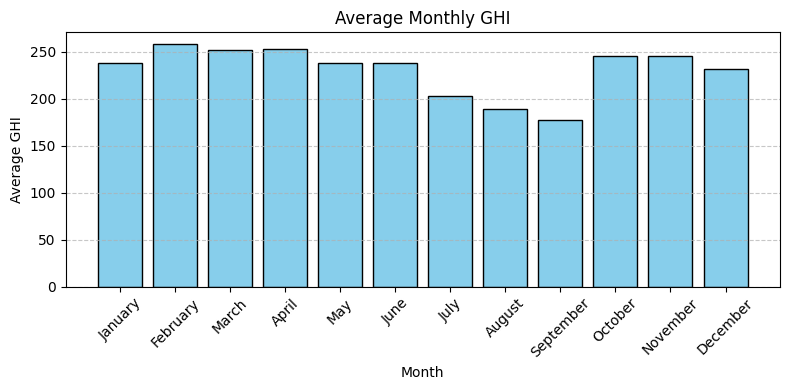

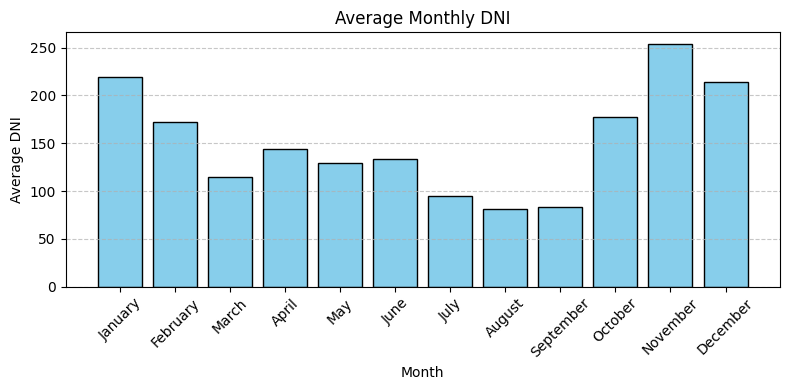

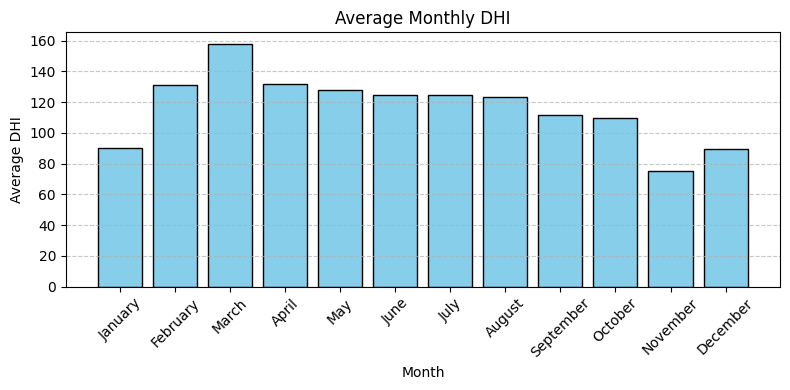

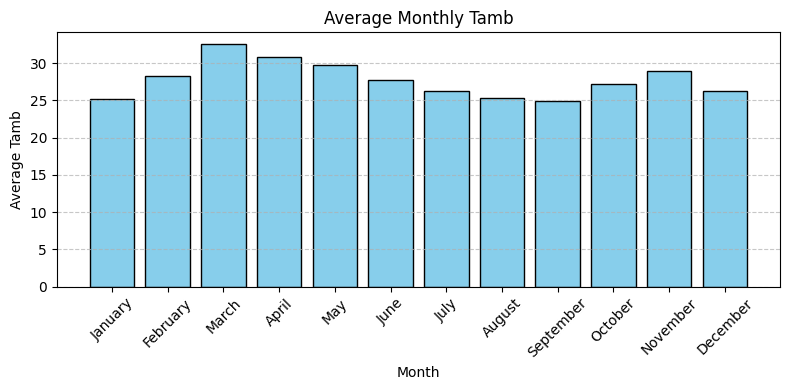

In [29]:
# Create new columns for Month
df["Month"] = df["Timestamp"].dt.month_name()
df["Month_num"] = df["Timestamp"].dt.month

# Calculate monthly averages for main metrics
monthly = df.groupby(["Month_num", "Month"])[["GHI", "DNI", "DHI", "Tamb"]].mean().reset_index()
monthly = monthly.sort_values("Month_num")

# Bar charts for each variable
for col in ["GHI", "DNI", "DHI", "Tamb"]:
    plt.figure(figsize=(8,4))
    plt.bar(monthly["Month"], monthly[col], color="skyblue", edgecolor="black")
    plt.title(f"Average Monthly {col}")
    plt.xlabel("Month")
    plt.ylabel(f"Average {col}")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


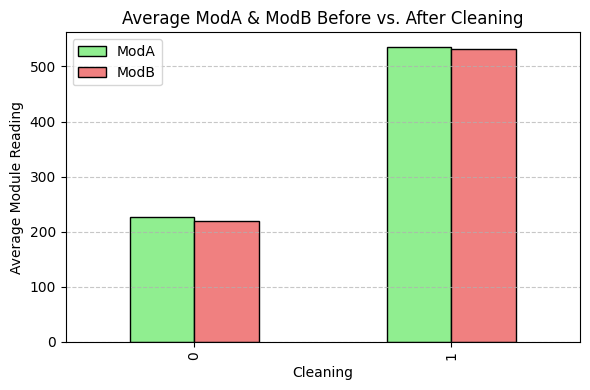

In [30]:
if "Cleaning" in df.columns:
    cleaning_group = df.groupby("Cleaning")[["ModA", "ModB"]].mean()

    cleaning_group.plot(kind="bar", figsize=(6,4), color=["lightgreen", "lightcoral"], edgecolor="black")
    plt.title("Average ModA & ModB Before vs. After Cleaning")
    plt.ylabel("Average Module Reading")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


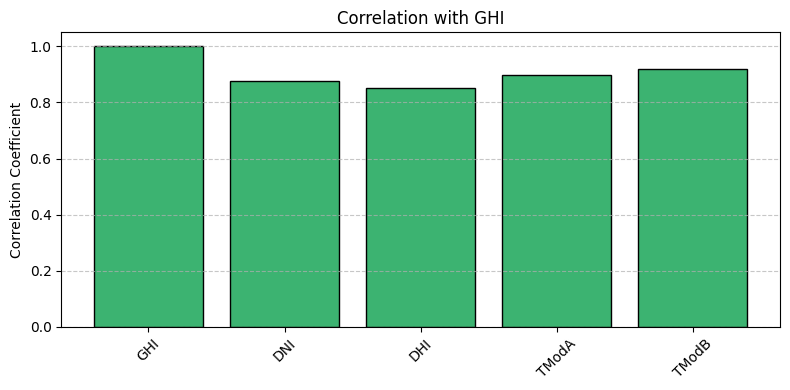

In [31]:
# Find correlation of each column with GHI
corr = df[["GHI", "DNI", "DHI", "TModA", "TModB"]].corr()["GHI"]

# Plot as bar chart
plt.figure(figsize=(8,4))
plt.bar(corr.index, corr.values, color="mediumseagreen", edgecolor="black")
plt.title("Correlation with GHI")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


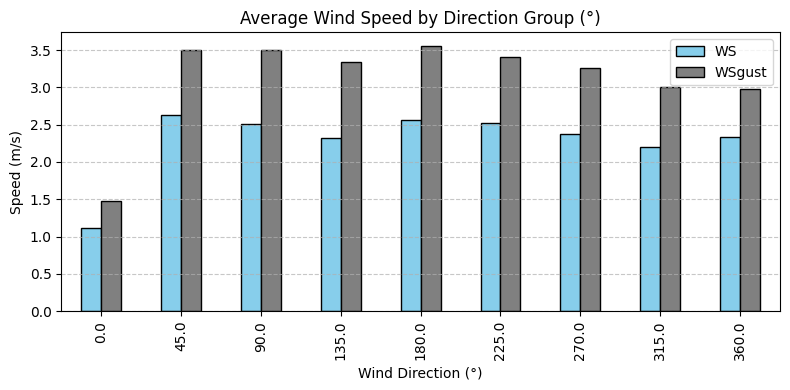

C:\Users\Gerji\AppData\Local\Temp\ipykernel_1348\1505330471.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rh_temp = df.groupby("RH_bin")["Tamb"].mean().reset_index()


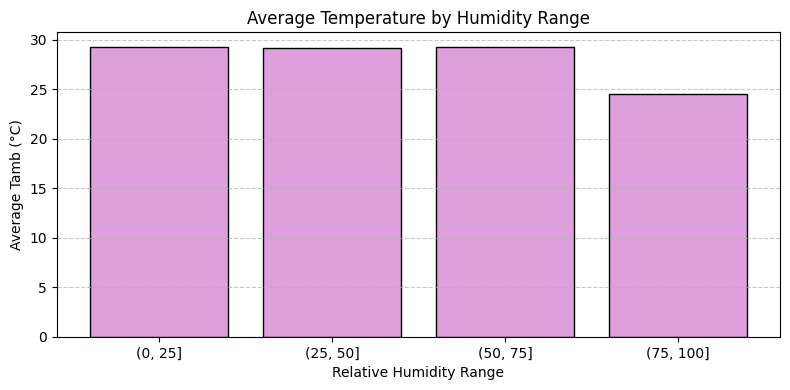

In [32]:
# Group wind by 45-degree direction segments
df["WD_group"] = (df["WD"] // 45) * 45
wind_avg = df.groupby("WD_group")[["WS", "WSgust"]].mean().reset_index()

# Wind speed bar chart
wind_avg.plot(x="WD_group", kind="bar", figsize=(8,4), edgecolor="black", color=["skyblue", "gray"])
plt.title("Average Wind Speed by Direction Group (°)")
plt.ylabel("Speed (m/s)")
plt.xlabel("Wind Direction (°)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Group temperature by humidity ranges
df["RH_bin"] = pd.cut(df["RH"], bins=[0,25,50,75,100])
rh_temp = df.groupby("RH_bin")["Tamb"].mean().reset_index()

# Temperature vs Humidity bar chart
plt.figure(figsize=(8,4))
plt.bar(rh_temp["RH_bin"].astype(str), rh_temp["Tamb"], color="plum", edgecolor="black")
plt.title("Average Temperature by Humidity Range")
plt.ylabel("Average Tamb (°C)")
plt.xlabel("Relative Humidity Range")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [33]:
df.to_csv("C:/Users/Gerji/Desktop/projects/solar-challenge-week1/data/benin-malanville.csv", index=False)
print("✅ Cleaned dataset saved as data/benin_clean.csv")


✅ Cleaned dataset saved as data/benin_clean.csv
